# Data format overview
## 1.0 Introduction
In this tutorial, we will overview and evaluate the following data formats
1. avro (structured)
2. csv (semi-structured)
3. json (semi-structured)
4. orc (structured)
5. parquet (structured) 

We evaluate the data formats by measuring the latency of the following data operations :
1. Disk usage
2. Read/Write latency
3. Random data lookup
4. Filtering/GroupBy(column-wise)
5. Distinct(row-wise)

## Important notes:
1. To avoid erreur, you need to execute the code block one by one from head to tail.
2. Some code block need to be modified. If you see a comment "#### Modify", you need to follow the instruction to modify the default value.
3. If you don't want to test each operation and generate stats, you can directly go to Section

## 2.0 Spark environment configuration
1. Create a spark session for running spark SQL operations
2. Setup a spark history server for monitoring and logging spark operations after the spark operations end.

In this section you need to modify the **bucket_name** value.

In [1]:
import os
import s3fs
endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})

#### Modify, you need to change the bucket_name to your own minio bucket name 
bucket_name="pengfei"

event_log_path="{}/tmp/spark-history".format(bucket_name)
fs.touch('s3://'+event_log_path+'/.keep')
fs.info(event_log_path)

{'Key': 'pengfei/tmp/spark-history',
 'name': 'pengfei/tmp/spark-history',
 'type': 'directory',
 'Size': 0,
 'size': 0,
 'StorageClass': 'DIRECTORY'}

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
       .builder.master("k8s://https://kubernetes.default.svc:443") \
       .appName("Evaluate data format") \
       .config("spark.kubernetes.container.image", "inseefrlab/jupyter-datascience:master") \
       .config("spark.kubernetes.authenticate.driver.serviceAccountName", os.environ['KUBERNETES_SERVICE_ACCOUNT']) \
       .config("spark.executor.instances", "5") \
       .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE']) \
       .config("spark.eventLog.enabled","true") \
       .config("spark.eventLog.dir","s3a://"+event_log_path) \
       .config("spark.jars.packages", "org.apache.spark:spark-avro_2.12:3.0.1") \
       .getOrCreate()


## 2.1 Setup data path
The data source is from https://www.kaggle.com/netflix-inc/netflix-prize-data?select=combined_data_1.txt. For saving some time, we just covert it to different format and uploaded it to our data lake. Because writing data takes much more time than reading. But we recoreded the latence of write operations, so we can analyze them after.  

In [3]:
json_data_path="s3a://pengfei/diffusion/data_format/netflix.json"
parquet_data_path="s3a://pengfei/diffusion/data_format/netflix.parquet"
avro_data_path="s3a://pengfei/diffusion/data_format/netflix.avro"
orc_data_path="s3a://pengfei/diffusion/data_format/netflix.orc"
csv_data_path="s3a://pengfei/diffusion/data_format/netflix.csv"

## 2.2 Some useful functions for evaluating data format

In this section, we define some useful functions which we will use after. You don't need to understand them to finish this tutorial. 

### 2.2.1 The read function read the source data file and convert it to a spark data frame

In [4]:
# file path for storing operation stats
data_format_op_stats_path="../tmp/op-stats.csv"

# file path for storing size stats
data_format_size_stats_path="../tmp/size-stats.csv"
def write_stats(line):
    file1 = open(data_format_op_stats_path,"a")
    file1.write(line+"\n")

In [5]:
import time
def read(fmt):
    start = time.time()
    if fmt == "json":
        sdf = spark.read.option("header", "true").json(json_data_path)
    elif fmt == "csv":
        sdf = spark.read.option("header", "true").csv(csv_data_path)
    elif fmt == "avro":
        sdf = spark.read.format("avro").load(avro_data_path)
    elif fmt == "parquet":
        sdf = spark.read.parquet(parquet_data_path)
    elif fmt == "orc":
        sdf = spark.read.orc(orc_data_path)
    sdf.show(5,False)
    stats="{}, {}, {}".format(fmt, "read", time.time() - start)
    write_stats(stats)
    print(stats)
    return sdf

### 2.2.2 The get_shape function prints the shape(e.g. row number and column number) of the data frame

In [6]:
def get_shape(df,fmt):
    start = time.time()
    row_num=df.count()
    col_num=len(df.columns)
    stats="{}, {}, {}".format(fmt, "get_shape", time.time() - start)
    write_stats(stats)
    print("The data frame has {} rows and {} columns".format(row_num,col_num))
    print(stats)

### 2.2.3 The stats function prints the min, max and numbers of a column of the data frame

In [7]:
def stats(df,fmt, field="rating"):
    start = time.time()
    max=df.agg({field: "max"})
    min=df.agg({field: "min"})
    count=df.agg({field: "count"})
    min.show(5,False)
    max.show(5,False)
    count.show(5,False)
    stats="{}, {}, {}".format(fmt, "stats", time.time() - start)
    write_stats(stats)
    print(stats)

### 2.2.4 The random_batch function randomly select rows from the data frame. It can evaluate the ability of random data lookup

In [8]:
def random_batch(df,fmt):
    start = time.time()
    result=df.sample(False, 0.05).collect()
    stats="{}, {}, {}".format(fmt, "random_batch", time.time() - start)
    write_stats(stats)
    print(stats)
   # return result

### 2.2.5 The distinct function count distinct rows of the data frame

In [9]:
def distinct(df,fmt):
    start = time.time()
    result = df.distinct().count()
    stats="{}, {}, {}".format(fmt, "distinct", time.time() - start)
    write_stats(stats)
    print(stats)
    return result

### 2.2.6 The group_by function group and count the data frame by a specific column

In [10]:
def group_by(df,fmt):
    start = time.time()
    result=df.groupBy("rating").count()
    result.show(5,False)
    stats="{}, {}, {}".format(fmt, "group_by", time.time() - start)
    write_stats(stats)
    print(stats)
    #return result

### 2.2.7 The filtering function filter data by using a specific boolean condition

In [11]:
def filtering(df, fmt, date="2005-11-15"):
    start = time.time()
    result = df.filter(df.date > date).count()
    stats="{}, {}, {}".format(fmt, "filtering", time.time() - start)
    write_stats(stats)
    print(stats)
    return result

### 2.2.8 The remove_space function removes space in string of a column to avoid filtering fail.

In [12]:
from pyspark.sql.functions import ltrim,rtrim,trim
def remove_space(df,col_name,position):
    # remove left side space
    if position =="l":
        return df.withColumn("tmp",ltrim(col(col_name))).drop(col_name).withColumnRenamed("tmp", col_name)
    # remove right side space
    elif position =="r":
        return df.withColumn("tmp",rtrim(col(col_name))).drop(col_name).withColumnRenamed("tmp", col_name)
    # remove all side space
    elif position =="a":
        return df.withColumn("tmp",trim(col(col_name))).drop(col_name).withColumnRenamed("tmp", col_name)

# 3. Gathering stats of each data format

## 3.1 Get CSV format evaluation stats

In [13]:
csv_df=read("csv")

+-------+------+----------+
|user_id|rating|date      |
+-------+------+----------+
|1488844|3     |2005-09-06|
|822109 |5     |2005-05-13|
|885013 |4     |2005-10-19|
|30878  |4     |2005-12-26|
|823519 |3     |2004-05-03|
+-------+------+----------+
only showing top 5 rows

csv, read, 12.375457048416138


In [14]:
csv_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- date: string (nullable = true)



In [15]:
get_shape(csv_df,"csv")

The data frame has 24058262 rows and 3 columns
csv, get_shape, 7.240294694900513


In [16]:
# get min, max and row number of column rating
stats(csv_df,"csv",field="rating")

+-----------+
|min(rating)|
+-----------+
|1          |
+-----------+

+-----------+
|max(rating)|
+-----------+
|5          |
+-----------+

+-------------+
|count(rating)|
+-------------+
|24053764     |
+-------------+

csv, stats, 22.793015480041504


In [20]:
random_batch(csv_df,"csv")

csv, random_batch, 13.7589590549469


In [21]:
distinct(csv_df,"csv")

csv, distinct, 18.58215618133545


12168704

In [22]:
group_by(csv_df,"csv")

+------+-------+
|rating|count  |
+------+-------+
|3     |6904181|
|null  |4498   |
|5     |5506583|
|1     |1118186|
|4     |8085741|
+------+-------+
only showing top 5 rows

csv, group_by, 8.768844604492188


In [23]:
filtering(csv_df,"csv")

csv, filtering, 6.811620235443115


850269

## 3.2 Get Json format evaluation stats

In [25]:
json_df=read("json")

+----------+------+-------+
|date      |rating|user_id|
+----------+------+-------+
|2005-09-06|3     |1488844|
|2005-05-13|5     |822109 |
|2005-10-19|4     |885013 |
|2005-12-26|4     |30878  |
|2004-05-03|3     |823519 |
+----------+------+-------+
only showing top 5 rows

json, read, 10.596537113189697


In [26]:
json_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- user_id: string (nullable = true)



In [27]:
get_shape(json_df,"json")

The data frame has 24058262 rows and 3 columns
json, get_shape, 7.124523162841797


In [28]:
# get min, max and row number of column rating
stats(json_df,"json",field="rating")

+-----------+
|min(rating)|
+-----------+
|1          |
+-----------+

+-----------+
|max(rating)|
+-----------+
|5          |
+-----------+

+-------------+
|count(rating)|
+-------------+
|24053764     |
+-------------+

json, stats, 27.224263906478882


In [29]:
random_batch(json_df,"json")

json, random_batch, 16.14436364173889


In [30]:
distinct(json_df,"json")

json, distinct, 20.182852268218994


12168704

In [31]:
group_by(json_df,"json")

+------+-------+
|rating|count  |
+------+-------+
|3     |6904181|
|null  |4498   |
|5     |5506583|
|1     |1118186|
|4     |8085741|
+------+-------+
only showing top 5 rows

json, group_by, 10.50503921508789


In [32]:
filtering(json_df,"json")

json, filtering, 8.807718753814697


850269

## 3.3 Get Avro format evaluation stats

In [33]:
avro_df=read("avro")

+-------+------+----------+
|user_id|rating|date      |
+-------+------+----------+
|1488844|3     |2005-09-06|
|822109 |5     |2005-05-13|
|885013 |4     |2005-10-19|
|30878  |4     |2005-12-26|
|823519 |3     |2004-05-03|
+-------+------+----------+
only showing top 5 rows

avro, read, 1.2825698852539062


In [34]:
get_shape(avro_df,"avro")

The data frame has 24058262 rows and 3 columns
avro, get_shape, 20.858465433120728


In [35]:
stats(avro_df,"avro",field="rating")

+-----------+
|min(rating)|
+-----------+
|1          |
+-----------+

+-----------+
|max(rating)|
+-----------+
|5          |
+-----------+

+-------------+
|count(rating)|
+-------------+
|24053764     |
+-------------+

avro, stats, 63.09317922592163


In [36]:
random_batch(avro_df,"avro")

avro, random_batch, 26.0331768989563


In [37]:
distinct(avro_df,"avro")

avro, distinct, 48.940186738967896


12168704

In [38]:
group_by(avro_df,"avro")

+------+-------+
|rating|count  |
+------+-------+
|3     |6904181|
|null  |4498   |
|5     |5506583|
|1     |1118186|
|4     |8085741|
+------+-------+
only showing top 5 rows

avro, group_by, 22.735329151153564


In [39]:
filtering(avro_df,"avro")

avro, filtering, 19.77875304222107


850269

## 3.4 Get Parquet format evaluation stats

In [40]:
parquet_df=read("parquet")

+-------+------+----------+
|user_id|rating|date      |
+-------+------+----------+
|1488844|3     |2005-09-06|
|822109 |5     |2005-05-13|
|885013 |4     |2005-10-19|
|30878  |4     |2005-12-26|
|823519 |3     |2004-05-03|
+-------+------+----------+
only showing top 5 rows

parquet, read, 2.200803756713867


In [41]:
get_shape(parquet_df,"parquet")

The data frame has 24058262 rows and 3 columns
parquet, get_shape, 0.9086737632751465


In [42]:
random_batch(parquet_df,"parquet")

parquet, random_batch, 188.6222629547119


In [43]:
stats(parquet_df,"parquet",field="rating")

+-----------+
|min(rating)|
+-----------+
|1          |
+-----------+

+-----------+
|max(rating)|
+-----------+
|5          |
+-----------+

+-------------+
|count(rating)|
+-------------+
|24053764     |
+-------------+

parquet, stats, 8.69551396369934


In [44]:
distinct(parquet_df,"parquet")

parquet, distinct, 208.28248143196106


12168704

In [45]:
group_by(parquet_df,"parquet")

+------+-------+
|rating|count  |
+------+-------+
|3     |6904181|
|null  |4498   |
|5     |5506583|
|1     |1118186|
|4     |8085741|
+------+-------+
only showing top 5 rows

parquet, group_by, 5.150459051132202


In [46]:
filtering(parquet_df,"parquet")

parquet, filtering, 1.9526302814483643


850269

## 3.5 Get ORC format evaluation stats

In [47]:
orc_df=read("orc")

+-------+------+----------+
|user_id|rating|date      |
+-------+------+----------+
|1488844|3     |2005-09-06|
|822109 |5     |2005-05-13|
|885013 |4     |2005-10-19|
|30878  |4     |2005-12-26|
|823519 |3     |2004-05-03|
+-------+------+----------+
only showing top 5 rows

orc, read, 2.2045276165008545


In [48]:
get_shape(orc_df,"orc")

The data frame has 24058262 rows and 3 columns
orc, get_shape, 1.186936616897583


In [49]:
random_batch(orc_df,"orc")

orc, random_batch, 7.036968469619751


In [50]:
stats(orc_df,"orc",field="rating")

+-----------+
|min(rating)|
+-----------+
|1          |
+-----------+

+-----------+
|max(rating)|
+-----------+
|5          |
+-----------+

+-------------+
|count(rating)|
+-------------+
|24053764     |
+-------------+

orc, stats, 4.8701817989349365


In [51]:
distinct(orc_df,"orc")

orc, distinct, 12.406772136688232


12168704

In [52]:
group_by(orc_df,"orc")

+------+-------+
|rating|count  |
+------+-------+
|3     |6904181|
|null  |4498   |
|5     |5506583|
|1     |1118186|
|4     |8085741|
+------+-------+
only showing top 5 rows

orc, group_by, 1.989671230316162


In [53]:
filtering(orc_df,"orc")

orc, filtering, 1.3489272594451904


850269

# 4. Evaluate the performence of different data formats 

## 4.1 Disk Usage for different  file format

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, DoubleType,StringType,LongType


# read size stats file

dfSize = pd.read_csv(data_format_size_stats_path,header=None, names=['format', 'size_kb'])
rawSizeDf=spark.createDataFrame(dfSize)
# generate a new column to make data humain readable
sizeDf=rawSizeDf.withColumn("size_mb",col("size_kb")/1024)
sizeDf.orderBy(col("size_kb").asc()).show(5)

+-------+-------+------------+
| format|size_kb|     size_mb|
+-------+-------+------------+
|   json|1292192|  1261.90625|
|    orc| 191332|186.84765625|
|parquet| 202772|198.01953125|
|   avro| 286628|279.91015625|
|    csv| 483432| 472.1015625|
+-------+-------+------------+
only showing top 5 rows



In [98]:
# convert spark df to pandas df
pd_size_df=sizeDf.toPandas()

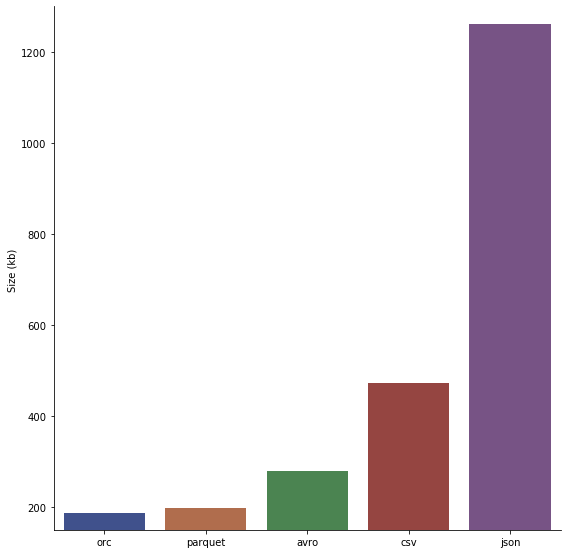

In [99]:
# show the stats in a catplot
g_size = sns.catplot(
    data=pd_size_df, kind="bar",
    x="format", y="size_mb", 
    order=['orc','parquet','avro','csv','json'],
    ci="sd", palette="dark", alpha=0.8, height=8
)
g_size.despine(left=False)
g_size.set_axis_labels("", "Size (kb) ")
g_size.set(ylim=(150, 1300))

The main objective of any file is to store data. It is necessary to store large volumes of different data types with less spaces. Because the disk usage can cost you a lot of money.

Based on the above graphe, we can have the obvious conclusion **do not use JSON or csv to store the raw data, and orc, parquet are the best solution for storing data.Now we want to know why?** 

Note that we used the default configuration for all format during the entire benchmark. So we do not specify any compression codec anywhere. As a result, we have the following table

| format | size(mb) | compression |
|--------|----------|-------------|
| json   | 1261.90  | None        |
| csv    | 472.10   | None        |
| avro   | 279.91   | None        |
| parquet| 198.01   | SNAPPY      |
| orc    | 186.84   | ZLIB        |


1. JSON uses the most space, because it has huge overhead on storing "schema". Each row must repeat the column name value, which are the same for all the rows (in our example, it represents 24058262 rows). 

2. CSV only has one line header for storing column names, so it uses much less space than JSON  
3. Avro does not do any compression, but it still uses less space than CSV. Because it saves raw data in binary. And the binary codec do a bit compression with storing int and long leveraging variable-length zig-zag coding.
4. Parque alson stores raw data in binary, and it does compress data. In spark, it uses SNAPPY as the default compressing codec.
5. Orc uses ZLIB as compression codec. As ZLIB can offer better compression ratio, so Orc use less space than Parquet. But Snappy is faster. 


You could argu that, you can gzip CSV and json which will reduce the disk usage. But, json and csv are not splitable after compression. As a result, we can not benefit from the parallel processing of Spark anymore. Thus, the advantage of avro, parquet and orc is obvious.

Note that avro, parquet and orc supports many compression codec. Here we only benchmark the default setting of each format. So the difference of disk usage between these three are negligible.

## 4.2 Visualize the data processing latency for each format

In this section, we will examine the latency of several the most common data processing operations to determine which format is more optimal in certain context. We will first examine the common operations one by one. At last, we will give you an overview and conclusion

In [100]:
# read stats file
dfLoc = pd.read_csv(data_format_op_stats_path,header=None, names=['format', 'command','latency'])
rawDf=spark.createDataFrame(dfLoc)
rawDf.show(5)

+------+------------+------------------+
|format|     command|           latency|
+------+------------+------------------+
|   csv|   get_shape| 4.477824687957764|
|   csv|       stats| 32.75556993484497|
|   csv|random_batch|14.378179788589478|
|   csv|    distinct|34.869959354400635|
|   csv|    group_by| 8.922224283218382|
+------+------------+------------------+
only showing top 5 rows



In [101]:
# remove duplicated rows
tmpDf=rawDf.dropDuplicates(["format","command"])
# remove space in command column
statsDf=remove_space(tmpDf,"command","l")
statsDf.count()

41

In [102]:
# convert to pandas df
pd_df=statsDf.toPandas()
pd_df.shape

(41, 3)

### 4.2.1 Read data

In [103]:
read_op_df=pd_df[pd_df.command.eq("read")]
read_op_df.head(5)

,format,latency,command
4,parquet,2.200804,read
21,avro,1.282570,read
23,json,10.596537,read
26,orc,2.204528,read
35,csv,8.125470,read


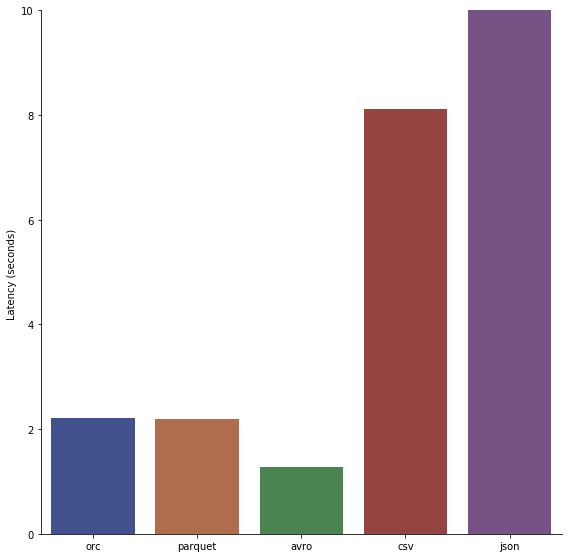

In [104]:
# show the stats in a catplot
g_read_op = sns.catplot(
    data=read_op_df, kind="bar",
    x="format", y="latency", 
    order=['orc','parquet','avro','csv','json'],
    ci="sd", palette="dark", alpha=0.8, height=8
)
g_read_op.despine(left=False)
g_read_op.set_axis_labels("", "Latency (seconds) ")
g_read_op.set(ylim=(0, 10))

You could notice that the reading speed of orc, parquet and avro are much faster than csv and json. Because they store raw data in binary, which are optimized for performence.

### 4.2.2 Get basic stats such as min, max, column numbers

The basic stats of a data set such as min, max, row numbers are the basic information we will gather when we exploring un data set. Below figure shows the latency of each format.

In [105]:
meta_op_df=pd_df.loc[(pd_df.command.eq("stats"))|(pd_df.command.eq("get_shape"))]
meta_op_df.head(5)

,format,latency,command
0,csv,32.755570,stats
5,csv,4.477825,get_shape
6,json,7.124523,get_shape
7,avro,20.858465,get_shape
10,json,27.224264,stats


Text(0.5, 0.98, ' Latency for basic stats operations ')

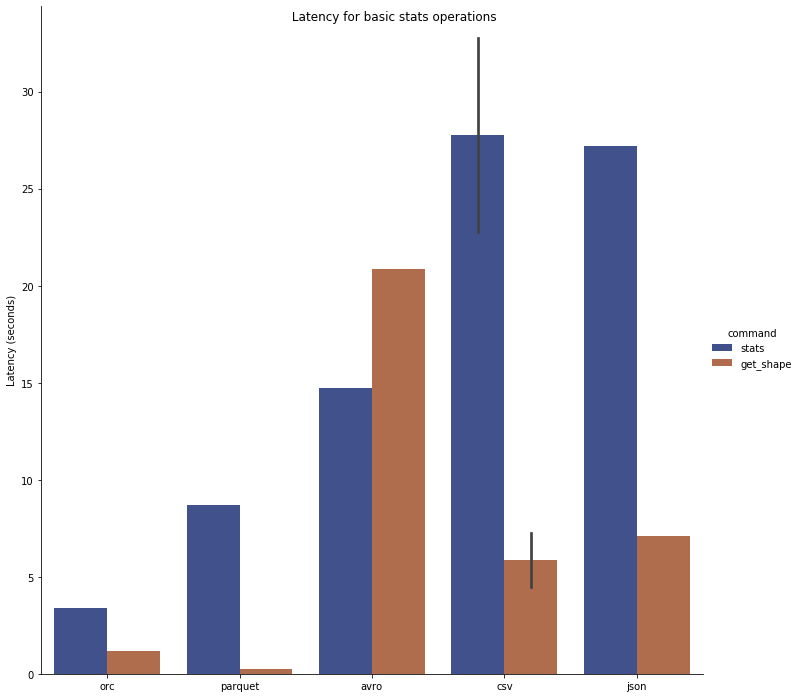

In [106]:
g_op_meta = sns.catplot(
    data=meta_op_df, kind="bar",
    x="format", y="latency", hue="command",
    order=['orc','parquet','avro','csv','json'],
    ci="sd", palette="dark", alpha=0.8, height=10
)
g_op_meta.despine(left=False)
g_op_meta.set_axis_labels("", "Latency (seconds)")
g_op_meta.fig.suptitle(' Latency for basic stats operations ')

Orc and Parquet saves the min, max and row numbers as metadata. So the basic stats operations do not require the process of the entire dataset.  

### 4.2.3 Random batch

Random batch select randomly a subset of rows in a dataframe. If checks the performence of radom access operations of a data format. Unlike sequential access, random access requires more sophisticated optimization to avoid read unnecessary data. 

In [107]:
random_op_df=pd_df[pd_df.command.eq("random_batch")]
random_op_df.head(5)

,format,latency,command
1,parquet,5.618207,random_batch
12,json,13.582443,random_batch
29,csv,14.378180,random_batch
30,avro,8.214335,random_batch
32,csv,14.898119,random_batch


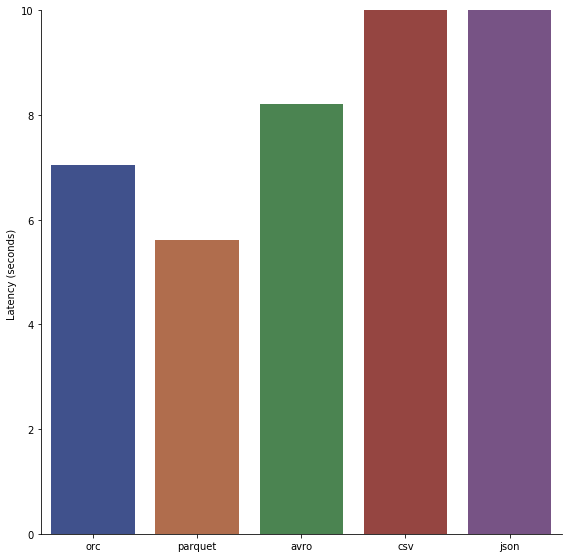

In [108]:
# show the stats in a catplot
g_random_op = sns.catplot(
    data=random_op_df, kind="bar",
    x="format", y="latency", 
    order=['orc','parquet','avro','csv','json'],
    ci="sd", palette="dark", alpha=0.8, height=8
)
g_random_op.despine(left=False)
g_random_op.set_axis_labels("", "Latency (seconds) ")
g_random_op.set(ylim=(0, 10))

orc, parquet, and avro split data in small chunks, and each chunk has a header which contains the metadata of the data in this chunk. As a result, when a certain row is required, the reader will check first the metadata in the header, if the condition is not matched, this chunk will be omitted. And this will avoid to read all unnecessary data 

### 4.2.4 column-wise operations (Filtering/GroupBy)

Many operations such as filtering or groupBy only instrested in data of certain columns. If we can avoid reading unnecessary data. We can improve dramatiquely the performence. Below figure shows the latency of filtering and groupBy operations. 

In [109]:
col_op_df=pd_df.loc[(pd_df.command.eq("group_by"))|(pd_df.command.eq("filtering"))]
col_op_df.head(5)

,format,latency,command
3,avro,22.735329,group_by
11,parquet,1.952630,filtering
13,json,9.966024,group_by
14,csv,8.922224,group_by
16,orc,0.517917,filtering


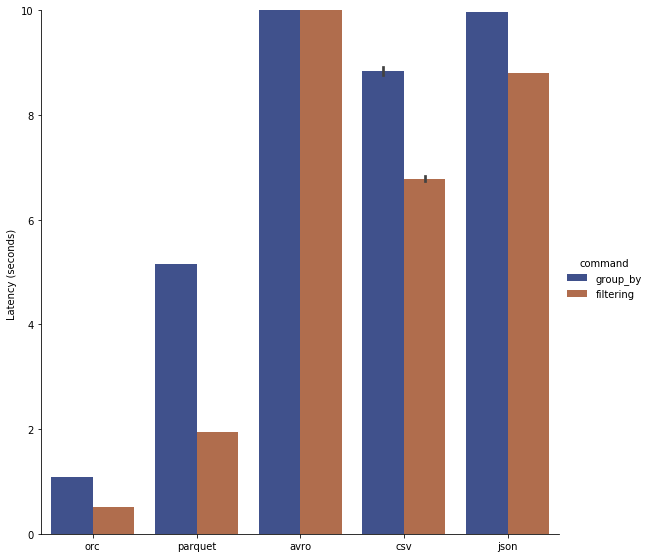

In [110]:
g_col_op = sns.catplot(
    data=col_op_df, kind="bar",hue="command",
    x="format", y="latency", 
    order=['orc','parquet','avro','csv','json'],
    ci="sd", palette="dark", alpha=0.8, height=8
)
g_col_op.despine(left=False)
g_col_op.set_axis_labels("", "Latency (seconds) ")
g_col_op.set(ylim=(0, 10))

We can notice orc and parquet are much quicker than avro, csv, and json. Because orc, and parquet are columnar-based data formats, and avro, csv, and json are row-based data formats. We will discuss the difference between columnar-based and row-based in another tutorial. 

### 4.2.5.row-wise operation (Distinct)

In [111]:
distinct_op_df=pd_df[pd_df.command.eq("distinct")]
distinct_op_df.head(5)

,format,latency,command
2,csv,34.869959,distinct
8,orc,24.495892,distinct
9,parquet,25.151234,distinct
15,avro,27.276218,distinct
17,json,20.182852,distinct


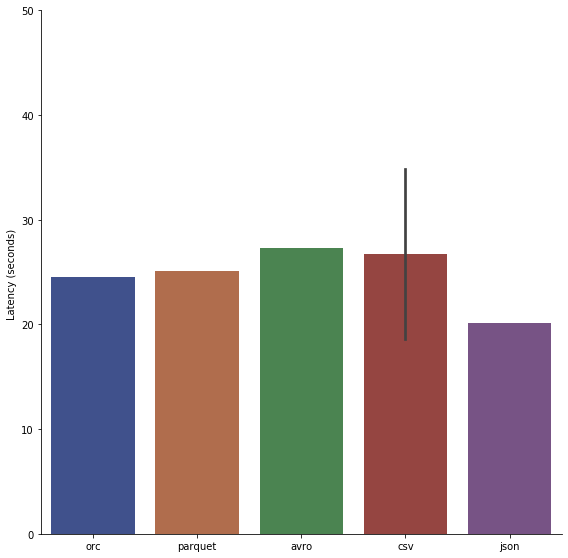

In [112]:
g_distinct_op = sns.catplot(
    data=distinct_op_df, kind="bar",
    x="format", y="latency", 
    order=['orc','parquet','avro','csv','json'],
    ci="sd", palette="dark", alpha=0.8, height=8
)
g_distinct_op.despine(left=False)
g_distinct_op.set_axis_labels("", "Latency (seconds) ")
g_distinct_op.set(ylim=(0, 50))

# 5. Overview and Conclusion

Text(0.5, 0.98, ' Latency for all operations ')

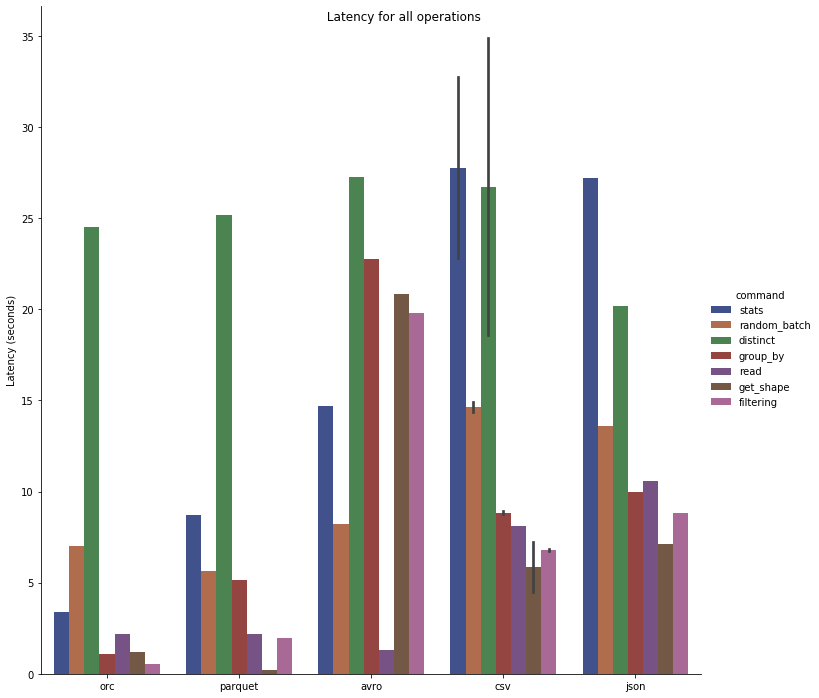

In [113]:
g_op = sns.catplot(
    data=pd_df, kind="bar",
    x="format", y="latency", hue="command",
    order=['orc','parquet','avro','csv','json'],
    ci="sd", palette="dark", alpha=0.8, height=10
)
g_op.despine(left=False)
g_op.set_axis_labels("", "Latency (seconds)")
g_op.fig.suptitle(' Latency for all operations ')

The above figure shows the overall operation latency of all data formats. You can easily spot the most appropriate format for you based on your use case.


## 5.1 Some basic properties of data format

We have seen the operation latency of all data formats. But there are other properties that may impact the choice of the data format. The below table shows some basic properties of data formats when we evaluate them. 


|Property |CSV |Json|Parquet|Avro|ORC|
|---------|----|----|-------|----|---|
|Human Readable|YES|YES|NO|NO|NO|
|Compressable|YES|YES|YES|YES|YES|
|Splittable|YES*|YES*|YES|YES|YES|
|Complex data structure|NO|YES|YES|YES|YES|
|Schema evolution|NO|NO|YES|YES|YES|
|Columnar|NO|NO|YES|NO|YES|

Note:

1. CSV is splittable when it is a raw, uncompressed file or using a splittable compression format such as BZIP2 or LZO (note: LZO needs to be indexed to be splittable!)
2. JSON has the same conditions about splittability when compressed as CSV with one extra difference. When “wholeFile” option is set to true in Spark(re: SPARK-18352), JSON is NOT splittable.

## 5.2 Best data format for OLAP: Parquet vs Orc

After the above analysis, we can say that Orc and Parquet are the best data formats for OLAP applications. They both support various compression algorithms which reduce significantly disk usage. They are both very efficient on columnar-oriented data analysis operations. 

Parquet has better support on nested data types than Orc. Orc loses compression ratio and analysis performance when data contains complex nested data types.

Orc supports data update and ACID (atomicity, consistency, isolation, durability). Parquet does not, so if you want to update a Parquet file, you need to create a new one based on the old one.

Parquet has better interoperability compare to Orc. Because almost all data analysis tools and framework supports parquet. Orc is only supported by Spark, Hive, Impala, MapReduce.

## 5.3 Conclusion

If you are building a data lake, warehouse, or mart. We strongly recommend you use Parquet as the default data format for all your data.
If you need to constantly update(write) your data, do not use columnar-based data formats such as ORC, Parquet.
If you need to update your data schema, use Avro.

As you know, when we load data from disk to memory via a tool (Spark, Hive, Pandas, etc), the tool needs to convert the file format(disk) to object models(memory). This conversion is very expensive, and each tool provides its own object models. To avoid the conversion of object models of different tools, a standard model has been proposed(i.e. Apache Arrow). Want to know more? Stay tuned for our next tutorial.


# Stop the spark cluster

In [114]:
# stop sparksession
spark.sparkContext.stop()

### Check if the spark cluster is well closed. You should not see any python-spark pods

In [115]:
! kubectl get pods

NAME                                                   READY   STATUS      RESTARTS   AGE
deleting-pods-with-completed-status-1620316800-zhrzv   0/1     Completed   0          44m
jupyter-1620315149-5c59999458-cnhnw                    1/1     Running     0          72m
mlflow-deployment-dd54d6c6b-xnglp                      1/1     Running     0          16d
mlflow-model-deployment-869dd96bbf-wlkhn               1/1     Running     0          14d
postgres-1616502799-67f86f5bdf-wfgjx                   1/1     Running     0          44d
ubuntu-1616490233-56d6684bb4-trwqt                     1/1     Running     1          44d
